## Training a model on MNIST

In [1]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import torch.nn as nn
import numpy as np
from tqdm import trange
import datetime

from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST, KMNIST, EMNIST
from torch.utils.data import Subset

import seaborn as sns
from matplotlib import pyplot as plt

from scripts.train_functions import create_dataloaders, main

## Using training scaffolding

In [2]:
root="~/data/"
batch_size = 100
dataset_name = "mnist"


In [3]:
dataloaders, dataset_sizes = create_dataloaders(root, batch_size, dataset_name=dataset_name)

In [4]:
# Select which dataset to use for training and validation
dataloaders['train'] = dataloaders['mnist_train']
dataset_sizes['train'] = dataset_sizes['mnist_train']
dataloaders['val'] = dataloaders['mnist_test']
dataset_sizes['val'] = dataset_sizes['mnist_test']

In [5]:
epochs = 40
# ckp_path, best_model_path, losses_path = main('mnist', epochs, dataloaders, dataset_sizes, ckp_path = "./checkpoint/current_checkpoint.pt", model_save_path = "./best_model/mnist/temp_model.pt", losses_path = "./losses/", resume=False)
print("Latest checkpoint saved at: ", ckp_path)
print("Best model saved at: ", best_model_path)
print("Losses saved at: ", losses_path)

Resuming?  False
Epoch 1/4
----------
train Loss: 0.8317
val Loss: 0.1874
Validation loss decreased (inf --> 0.187424).  Saving model ...
Epoch 2/4
----------
train Loss: 0.1486
val Loss: 0.1308
Validation loss decreased (0.187424 --> 0.130831).  Saving model ...
Epoch 3/4
----------
train Loss: 0.0953
val Loss: 0.0936
Validation loss decreased (0.130831 --> 0.093574).  Saving model ...
Epoch 4/4
----------
train Loss: 0.0730
val Loss: 0.0746
Validation loss decreased (0.093574 --> 0.074646).  Saving model ...
Latest checkpoint saved at:  ./checkpoint/current_checkpoint.pt
Best model saved at:  ./best_model/mnist/temp_model.pt
Losses saved at:  ./losses/


## All in one notebook

In [2]:
# DNN mapping 2d input to 1d distribution parameter
# LeNet v5
model = nn.Sequential(
        nn.Conv2d(1, 6, 5, 1),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Conv2d(6, 16, 5, 1),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Flatten(),
        nn.Linear(256, 120),
        nn.ReLU(),
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Linear(84,10)
    )

dist_layer = scod.distributions.CategoricalLogitLayer()

In [3]:
device=torch.device('cpu')
model = model.to(device)

In [4]:
train_dataset = MNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))

mean_loss=0.014400,lr=0.000000: 100%|██████████| 500/500 [1:03:13<00:00,  7.59s/it]


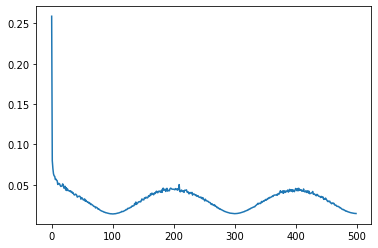

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)

losses = []
# t = trange(100)
t = trange(500)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs.to(device))
        dist = dist_layer(outputs)
        loss = -dist.log_prob(targets.to(device))

        mean_loss = loss.mean()

        regularization = torch.sum(torch.stack([torch.norm(p)**2 for p in model.parameters()])) / 2e3

        total_loss = mean_loss + regularization

        total_loss.backward()

        epoch_loss += mean_loss
        
        optimizer.step()
    scheduler.step()
        
    epoch_loss /= len(train_dataloader)
    
    t.set_description("mean_loss=%02f,lr=%02f"%(epoch_loss.item(),scheduler.get_last_lr()[0]))
    losses.append(epoch_loss.item())

plt.plot(losses)

In [6]:
# create checkpoint variable and add important data
checkpoint = {
    'epoch': epoch + 1,
    'valid_loss': epoch_loss,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}


In [7]:
# save_model_path = "../best_model/mnist_model.pt"
# losses_path = "../losses/"

# save_model_path = "../best_model/overtrained_mnist_model.pt"
# losses_path = "../losses/"

In [8]:
# torch.save(checkpoint, save_model_path)

In [18]:
# # Save train losses and valid losses
# fname = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +'.npz' 
# np.savez(losses_path + fname, train_loss_values = losses)